In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pymesh
#https://pymesh.readthedocs.io/en/latest/basic.html
# https://github.com/PyMesh/PyMesh


import meshplot
# for display of meshes
#https://skoch9.github.io/meshplot/tutorial/

import random

from multiprocessing import Pool #  Process pool
from multiprocessing import sharedctypes
import time
from functools import partial
#MULTITHREADING Adjustment
#Sample Multithreading Code 
# from https://jonasteuwen.github.io/numpy/python/multiprocessing/2017/01/07/multiprocessing-numpy-array.html
# https://thebinarynotes.com/python-multiprocessing/


# nicer plots
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

from pathos.multiprocessing import ProcessingPool as Poolp

# shape models available here:
#https://www.naic.edu/~smarshal/1999kw4.html
#Squannit is secondary of Moshup which was 1999KW4


### code for BYORP calculation


The surface thermal inertia is neglected, so that thermal radiation is re-emitted with no time lag, and the reflected and thermally radiated components are assumed Lambertian (isotropic) and so emitted with flux
parallel to the local surface normal. We ignore heat conduction. The surface is described with a closed
triangular mesh.


The radiation force from the $i$-th facet is
$$ {\bf F}_i  = - \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot) \hat {\bf n}_i $$
where  $S_i$ is the area of the $i$-th facet and $\hat {\bf n}_i$ is its surface normal.
Here $F_\odot$ is the solar radiation flux and $c$ is the speed of light.
The direction of the Sun is $\hat {\bf s}_\odot$.

The total Yarkovsky force is a sum over all the facets 
$${\bf F}_Y = \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} {\bf F}_i $$
Only facets on the day side  or with $\hat {\bf n}_i \cdot \hat {\bf s}_\odot >0$ 
are included in the sum.

The torque affecting the binary orbit from a single facet is 
$$ {\boldsymbol \tau}_{i,B} = 
\begin{cases} 
- \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot) ( {\bf a}_B \times \hat {\bf n}_i)  
 & \mbox{if } \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0  \\
 0 & \mbox{otherwise}
 \end{cases}
$$
where ${\bf a}_B$ is the secondary's radial vector from the binary center of mass.


The torque affecting the binary orbit is the sum of the torques from each facet and should be an average 
over the orbit around the Sun and 
over the binary orbit and spin of the secondary.
$$ {\boldsymbol \tau}_{BY} = \frac{1}{T} \int_0^T dt\   \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} 
{\boldsymbol \tau}_{i,B} $$


If $\hat {\bf l}$ is the binary orbit normal then 
$$ {\boldsymbol \tau}_{BY} \cdot \hat {\bf l} $$ 
changes the binary's orbital angular momentum and causes binary orbit migration.


The torque affecting the spin (also known as YORP) instantaneously depends on 
the radii of each facit ${\bf r}_i$ from the asteroid center of mass 
$$ {\boldsymbol \tau}_{i,s}  = \begin{cases}
- \frac{F_\odot}{c} {S_i} (\hat {\bf n}_i \cdot \hat {\bf s}_\odot)  ({\bf r}_i \times \hat{\bf n}_i) 
 & \mbox{if } \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0  \\
0 & \mbox{otherwise}
\end{cases}$$


$$ {\boldsymbol \tau}_Y = \frac{1}{T} \int_0^T dt \  \sum_{i: \hat {\bf n}_i \cdot \hat {\bf s}_\odot >0} {\boldsymbol \tau}_{i,s} $$
where the average is done over the orbit about the Sun and the spin of the asteroid.
If the spin axis is $\hat {\boldsymbol \omega}$ then 
$$ {\boldsymbol \tau}_Y \cdot \hat {\boldsymbol \omega}  $$ gives the body spin up or spin down rate.


In practice we average over the Sun's directions first and then average over spin (for YORP) or and spin and binary orbit direction (for BYORP) afterward.


<b> Units </b> 

For our calculation are $F_\odot/c = 1$.

For YORP $R=1$.
For BYORP $a_B = 1$ and $R=1$ (in the surface area).

Here $R$ is volume equivalent sphere radius.

To put in physical units: 

Multiply ${\boldsymbol \tau}_Y$ by $\frac{F_\odot R^3}{c}$.

Multiply ${\boldsymbol \tau}_{BY}$ by $\frac{F_\odot R^2 a_B}{c}$.

Alternatively we are computing:

${\boldsymbol \tau}_Y \times \frac{c}{F_\odot R^3} $ 

${\boldsymbol \tau}_{BY} \times \frac{c}{F_\odot R^2 a_B} $ 


To get the rate the spin changes for YORP

$\dot \omega = \frac{ {\boldsymbol \tau}_Y \cdot \hat {\bf s} }{C} $

where $C$ is the moment of inertia about the spin axis.

To order of magnitude what we are computing can be multiplied by 
$\frac{F_\odot R^3}{c MR^2} $ to estimate $\dot \omega$
and by $\frac{F_\odot R^3}{c MR^2 \omega} $
to estimate $\dot \epsilon$. 

To get the rate that obliquity changes for YORP

$\dot \epsilon = \frac{ {\boldsymbol \tau}_Y \cdot \hat {\boldsymbol \phi} }{C \omega} $

where unit vector $\hat {\boldsymbol \phi}$ is in the xy plane (ecliptic) and is perpendicular to the spin axis.

To get the semi-major axis drift rate for BYORP

$ \dot a_B = \frac{2 {\boldsymbol \tau}_{BY} \cdot \hat {\bf l}}{M n_Ba_B} $

where $M$ is the secondary mass, $n_B$ and $a_B$ are binary orbit mean motion and semi-major axis.

To order of magnitude to get the drift rate we multiply what we are getting by 
$\frac{F_\odot R^2 a_B}{c} \times \frac{1}{M n_B a_B}$.


Dimensionless numbers used by Steiberg+10 (eqns 19,48)

$f_{Y} \equiv \tau_{Y} \frac{3}{2} \frac{c}{\pi R^3 F_\odot}$

$f_{BY} \equiv \tau_{BY} \frac{3}{2} \frac{c}{\pi R^2 a_B F_\odot}$

Our computed values are  the same as theirs except for a factor of 3/2 
(but they have a 2/3 in their torque) and a factor of $\pi$.
We need to divide by $\pi$ to have values consistent with theirs.

<b> Assumptions:</b>

Circular orbit for binary.

Circuilar orbit for binary around Sun.

No shadows.

No conduction. Lambertian isotropic emission. No thermal lag.

We neglect distance of facet centroids from secondary center of mass when computing BYORP. 

Coordinate system:
binary orbit is kept in xy plane

Compare YORP on primary to BYORP on secondary.

$\frac{\tau_{Yp}}{\tau_{BY} }\sim \frac{R_p^2 }{R_s^2 } \frac{R_p }{a_B }\frac{f_Y}{ f_{BY}}$

For Didymos, this is about $8 f_Y/f_{BY}$.

In [2]:
random.seed(1)
print(random.uniform(-1,1))

-0.7312715117751976


In [3]:
# perturb a sphere (mesh, premade) and stretch it so that
# it becomes an ellipsoid.  
#    We can't directly edit vertices or faces
#    see this:  https://github.com/PyMesh/PyMesh/issues/156
#    the work around is to copy the entire mesh after modifying it
# arguments:
#   devrand,  Randomly add devrand to x,y,z positions of each vertex
#     a uniform ditns in [-1,1] is used
#   aratio1 and aratio2,  stretch or compress a sphere by aratio1 and aratio2 
# returns: a new mesh
# we assume that longest semi-major axis a is along x, 
#    medium semi-axis b is along y, semi-minor c axis is along z
# Volume should stay the same!
def sphere_perturb(sphere,devrand,aratio1,aratio2):
    #devrand = 0.05  # how far to perturb each vertex
    nv = len(sphere.vertices)
    f = sphere.faces
    v = np.copy(sphere.vertices)
    # add perturbations to x,y,z to all vertices
    for i in range(nv):
        dx = devrand*random.uniform(-1,1)
        dy = devrand*random.uniform(-1,1)
        dz = devrand*random.uniform(-1,1)
        v[i,0] += dx
        v[i,1] += dy
        v[i,2] += dz
        
    
    # aratio1 = c/a  this gives c = aratio1*a
    # aratio2 = b/a  this gives b = aratio2*a
    # volume = 4/3 pi a*b*c for an ellipsoid
    # vol = 1*aratio1*aratio2
    # rad_cor = pow(vol,-1./3.)
    # v[:,2] *= aratio1*rad_cor # make oblate, adjusts z coords
    # v[:,1] *= aratio2*rad_cor # make elongated in xy plane , adjusts y coords
    #  v[:,0] *= rad_cor # adjusts x coords
    # volume should now stay the same
        
    sub_com(v) # subtract center of mass from vertex positions
    psphere = pymesh.form_mesh(v, f)
    psphere.add_attribute("face_area")
    psphere.add_attribute("face_normal")
    psphere.add_attribute("face_centroid")
    
    sbody = body_stretch(psphere,aratio1,aratio2)  # do the stretching 
    return sbody
                         

# stretch a mesh body by axis ratios 
# arguments:
#    body: mesh
#    aratio1: c/a
#    aratio2: b/a
# returns: a new mesh
# we assume that longest semi-major axis a is along x, 
#    medium semi-axis b is along y, semi-minor c axis is along z
# Volume should stay the same!
def body_stretch(body,aratio1,aratio2):
    nv = len(body.vertices)
    f = body.faces
    v = np.copy(body.vertices)
    
    # aratio1 = c/a  this gives c = aratio1*a
    # aratio2 = b/a  this gives b = aratio2*a
    # volume = 4/3 pi a*b*c for an ellipsoid
    vol = 1*aratio1*aratio2
    rad_cor = pow(vol,-1./3.)
    v[:,2] *= aratio1*rad_cor # make oblate, adjusts z coords
    v[:,1] *= aratio2*rad_cor # make elongated in xy plane , adjusts y coords
    v[:,0] *= rad_cor # adjusts x coords
    # volume should now stay the same
    
    sub_com(v) # subtract center of mass from vertex positions
    sbody = pymesh.form_mesh(v, f)
    sbody.add_attribute("face_area")
    sbody.add_attribute("face_normal")
    sbody.add_attribute("face_centroid")
    return sbody
    

# substract the center of mass from a list of vertices
def sub_com(v):
    nv = len(v)
    xsum = np.sum(v[:,0])
    ysum = np.sum(v[:,1])
    zsum = np.sum(v[:,2])
    xmean = xsum/nv
    ymean = ysum/nv
    zmean = zsum/nv
    v[:,0]-= xmean 
    v[:,1]-= ymean 
    v[:,2]-= zmean 
    
# compute surface area by summing area of all facets   
# divide by 4pi which is the surface area of a sphere with radius 1
def surface_area(mesh):
    #f = mesh.faces
    S_i = mesh.get_face_attribute('face_area') 
    area =np.sum(S_i)
    return area/(4*np.pi)


# print number of faces
def nf_mesh(mesh):   
    f = mesh.faces
    print('number of faces ',len(f))

In [4]:
# meshplot with a bounding box
def plt_mesh(vertices,faces,xmax):
    m = np.array([-xmax,-xmax,-xmax])
    ma = np.abs(m)

    # Corners of the bounding box
    v_box = np.array([[m[0], m[1], m[2]], [ma[0], m[1], m[2]], [ma[0], ma[1], m[2]], [m[0], ma[1], m[2]],
                  [m[0], m[1], ma[2]], [ma[0], m[1], ma[2]], [ma[0], ma[1], ma[2]], [m[0], ma[1], ma[2]]])

    # Edges of the bounding box
    f_box = np.array([[0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 7], 
                  [7, 4], [0, 4], [1, 5], [2, 6], [7, 3]], dtype=np.int)

    p = meshplot.plot(vertices, faces, return_plot=True)  # plot body

    p.add_edges(v_box, f_box, shading={"line_color": "red"});
    #p.add_points(v_box, shading={"point_color": "green"})
    return p


# meshplot with a bounding square
def plt_mesh_square(vertices,faces,xmax):
    m = np.array([-xmax,-xmax,-xmax])
    ma = np.abs(m)

    # Corners of the bounding box
    v_box = np.array([[-xmax, -xmax, 0], [-xmax, xmax, 0], [xmax, xmax,0] , [xmax, -xmax, 0]])

    # Edges of the bounding box
    f_box = np.array([[0, 1], [1, 2], [2, 3], [3, 0]], dtype=np.int)

    p = meshplot.plot(vertices, faces, return_plot=True)  # plot body

    p.add_edges(v_box, f_box, shading={"line_color": "red"});
    #p.add_points(v_box, shading={"point_color": "green"})
    return p


# perform a rotation on a vertex list and return a new set of rotated vertices
# rotate about axis and via angle in radians
def rotate_vertices(vertices,axis,angle):
    qs = pymesh.Quaternion.fromAxisAngle(axis, angle)
    v = np.copy(vertices)
    nv = len(v)
    # loop over all vertices and do two rotations
    for i in range(nv):
        v[i] = qs.rotate(v[i]) # perform rotation
    return v


In [5]:
# compute the volume of the tetrahedron formed from face with index iface
# and the origin
def vol_i(mesh,iface):
    f = mesh.faces
    v = mesh.vertices
    iv1 = f[iface,0]  # indexes of the 3 vertices
    iv2 = f[iface,1]
    iv3 = f[iface,2]
    #print(iv1,iv2,iv3)
    v1 = v[iv1]  # the 3 vertices
    v2 = v[iv2]
    v3 = v[iv3]
    #print(v1,v2,v3)
    mat = np.array([v1,v2,v3])  
    # the volume is equal to 1/6 determinant of the matrix formed with the three vertices
    # https://en.wikipedia.org/wiki/Tetrahedron
    #print(mat)
    vol = np.linalg.det(mat)/6.0  # compute determinant
    return vol

# compute the volume of the mesh by looping over all tetrahedrons formed from the faces
# we assume that the body is convex
def volume_mesh(mesh):
    f = mesh.faces
    nf = len(f)
    vol = 0.0
    for iface in range(nf):
        vol += vol_i(mesh,iface)
    return vol
        
# if vol equ radius is 1  the volume should be equal to 4*np.pi/3 which is 4.1888 
    
# tests  
#vi = vol_i(squannit,1)
#print(vi)
#vtot = volume_mesh(squannit)
#print(vtot)

# correct all the radii so that the volume becomes that of a sphere with radius 1
# return a new mesh
def cor_volume(mesh):
    vol = volume_mesh(mesh)
    print('Volume {:.4f}'.format(vol))
    rad = pow(vol*3/(4*np.pi),1.0/3.0)
    print('radius of vol equ sphere {:.4f}'.format(rad))
    f = mesh.faces
    v = np.copy(mesh.vertices)
    v /= rad
    newmesh = pymesh.form_mesh(v, f)
    newmesh.add_attribute("face_area")
    newmesh.add_attribute("face_normal")
    newmesh.add_attribute("face_centroid")
    vol = volume_mesh(newmesh)
    print('new Volume {:.3f}'.format(vol))
    return newmesh
    

In [6]:
# compute the radiation force instantaneously on a triangular mesh for each facit
# arguments:  
#     mesh, the body (a triangular surface mesh)
#     s_hat is a 3 length np.array (a unit vector) pointing to the Sun
# return the vector F_i for each facet
# returns:  F_i_x is the x component of F_i and is a vector that has the length of the number of faces
# Force is zero if facets are not on the day side
def F_i(mesh,s_hat):
    s_len = np.sqrt(s_hat[0]**2 + s_hat[1]**2 + s_hat[2]**2)  # in case s_hat was not normalized
    #nf = len(mesh.faces)
    S_i = mesh.get_face_attribute('face_area')  # vector of facet areas
    f_normal = mesh.get_face_attribute('face_normal')  # vector of vector of facet normals
    # normal components 
    nx = np.squeeze(f_normal[:,0])    # a vector, of length number of facets
    ny = np.squeeze(f_normal[:,1])
    nz = np.squeeze(f_normal[:,2])
    # dot product of n_i and s_hat
    n_dot_s = (nx*s_hat[0] + ny*s_hat[1] + nz*s_hat[2])/s_len  # a vector
    F_i_x = -S_i*n_dot_s*nx #  a vector, length number of facets
    F_i_y = -S_i*n_dot_s*ny
    F_i_z = -S_i*n_dot_s*nz
    ii = (n_dot_s <0)  # the night sides 
    F_i_x[ii] = 0  # get rid of night sides
    F_i_y[ii] = 0
    F_i_z[ii] = 0
    return F_i_x,F_i_y,F_i_z   # these are each vectors for each face

# compute radiation forces F_i for each face, but averaging over all positions of the Sun
# a circular orbit for the asteroid is assumed
# arguments: 
#    nphi_Sun is the number of solar angles, evenly spaced in 2pi so we are assuming circular orbit
#    incl is solar orbit inclination in radians
# returns: F_i_x average and other 2 components of forces for each facet
def F_i_sun_ave(mesh,nphi_Sun,incl):
    dphi = 2*np.pi/nphi_Sun
    # compute the first set of forces so we have vectors the right length
    phi = 0.0
    s_hat = np.array([np.cos(phi)*np.cos(incl),np.sin(phi)*np.cos(incl),np.sin(incl)])
    # compute the radiation force instantaneously on the triangular mesh for sun at s_hat
    F_i_x_sum,F_i_y_sum,F_i_z_sum = F_i(mesh,s_hat)
    # now compute the forces for the rest of the solar angles
    for i in range(1,nphi_Sun): # do the rest of the angles
        phi = i*dphi
        s_hat = np.array([np.cos(phi)*np.cos(incl),np.sin(phi)*np.cos(incl),np.sin(incl)])
        # compute the radiation force instantaneously on the triangular mesh for sun at s_hat
        F_i_x,F_i_y,F_i_z = F_i(mesh,s_hat)  # These are vectors of length number of facets
        F_i_x_sum += F_i_x  # sum up forces
        F_i_y_sum += F_i_y
        F_i_z_sum += F_i_z
    F_i_x_ave = F_i_x_sum/nphi_Sun  # average
    F_i_y_ave = F_i_y_sum/nphi_Sun
    F_i_z_ave = F_i_z_sum/nphi_Sun
    return F_i_x_ave,F_i_y_ave,F_i_z_ave  # these are vectors for each face

# compute cross product C=AxB using components
def cross_prod_xyz(Ax,Ay,Az,Bx,By,Bz):
    Cx = Ay*Bz - Az*By
    Cy = Az*Bx - Ax*Bz
    Cz = Ax*By - Ay*Bx
    return Cx,Cy,Cz

# compute total Yorp torque averaging over nphi_Sun solar positions
# this is at a single body orientation
# a circular orbit is assumed
# arguments:
#   mesh: the body
#   nphi_Sun is the number of solar angles
#   incl is solar orbit inclination in radians
# returns: torque components
def tau_Ys(mesh,nphi_Sun,incl):
    # compute F_i for each face, but averaging over all positions of the Sun
    F_i_x_ave, F_i_y_ave,F_i_z_ave = F_i_sun_ave(mesh,nphi_Sun,incl)
    r_i = mesh.get_face_attribute("face_centroid")  # radii to each facet
    rx = np.squeeze(r_i[:,0])  # radius of centroid from center of mass
    ry = np.squeeze(r_i[:,1])  # these are vectors, length number of faces
    rz = np.squeeze(r_i[:,2])
    # cross product works on vectors
    tau_i_x,tau_i_y,tau_i_z = cross_prod_xyz(rx,ry,rz,F_i_x_ave,F_i_y_ave,F_i_z_ave)
    #This is the torque from each day lit facet
    tau_x = np.sum(tau_i_x)  # sum up forces from all faces
    tau_y = np.sum(tau_i_y)
    tau_z = np.sum(tau_i_z)
    return tau_x,tau_y,tau_z  # these are numbers for torque components

# compute total BYORP averaging over nphi_Sun solar positions
# for a single binary vector a_bin and body position described with mesh
# arguments:
#    incl is solar orbit inclination in radians
#    nphi_Sun is the number of solar angles
# returns: torque components
def tau_Bs(mesh,nphi_Sun,incl,a_bin):
    # compute F_i for each face, but averaging over all positions of the Sun
    F_i_x_ave, F_i_y_ave,F_i_z_ave = F_i_sun_ave(mesh,nphi_Sun,incl)  # these are vectors length number of faces
    # forces from day lit faces
    F_x = np.sum(F_i_x_ave)  #sum up the force
    F_y = np.sum(F_i_y_ave)
    F_z = np.sum(F_i_z_ave)
    a_x = a_bin[0]  # binary direction
    a_y = a_bin[1]
    a_z = a_bin[2]
    tau_x,tau_y,tau_z = cross_prod_xyz(a_x,a_y,a_z,F_x,F_y,F_z) # cross product
    return tau_x,tau_y,tau_z  # these are numbers that give the torque components
        

In [7]:
# first rotate vertices in the mesh about the z axis by angle phi in radians
# then tilt over the body by obliquity which is an angle in radians
# arguments:
#    mesh, triangular surface mess for body
#    obliquity, angle in radius to tilt body z axis over
#    phi, angle in radians to spin/rotate body about its z axis
#    phi_prec,  angle in randias that tilt is done, it's a precession angle
#      sets rotation axis for tilt, this axis is in the xy plane
# returns: 
#     new_mesh: the tilted/rotated mesh
#     zrot:  the new z-body spin axis
def tilt_obliq(mesh,obliquity,phi,phi_prec):
    f = mesh.faces
    v = np.copy(mesh.vertices)
    nv = len(v)
    
    # precession angle is phi_prec
    axist = np.array([np.cos(phi_prec),np.sin(phi_prec),0])  
    qt = pymesh.Quaternion.fromAxisAngle(axist, obliquity)
    zaxis = np.array([0,0,1])
    
    zrot = qt.rotate(zaxis) # body principal axis will become zrot
    
    # spin rotation about now tilted principal body axis 
    qs = pymesh.Quaternion.fromAxisAngle(zrot, phi)
    
    # loop over all vertices and do two rotations
    for i in range(nv):
        v[i] = qt.rotate(v[i]) # tilt it over
        v[i] = qs.rotate(v[i]) # spin
    
    new_mesh = pymesh.form_mesh(v, f)
    new_mesh.add_attribute("face_area")
    new_mesh.add_attribute("face_normal")
    new_mesh.add_attribute("face_centroid")
    
    return new_mesh,zrot
    

# tilt,spin a body and compute binary direction, assuming tidally locked
# arguments:
#   body:  triangular surface mesh (in principal axis coordinate system)
#   nphi is the number of angles that could be done with indexing by iphi
#   obliquity:  w.r.t to binary orbit angular momentum direction
#   iphi:  number of rotations by dphi where dphi = 2pi/nphi
#      this is principal axis rotation about z axis
#   phi0: an offset for phi applied to body but not binary axis
#   phi_prec: a precession angle for tilting
# returns: 
#   tbody, a body rotated  after iphi rotations by dphi and tilted by obliquity
#   a_bin, binary direction assuming same rotation rate, tidal lock
#   l_bin:  binary orbit angular momentum orbital axis
#   zrot:  spin axis direction 
def tilt_and_bin(body,obliquity,nphi,iphi,phi0,phi_prec):
    dphi = 2*np.pi/nphi
    phi = iphi*dphi 
    tbody,zrot = tilt_obliq(body,obliquity,phi + phi0,phi_prec)  # tilt and spin body
    a_bin = np.array([np.cos(phi),np.sin(phi),0.0])   # direction to binary
    l_bin = np.array([0,0,1.0])  # angular momentum axis of binary orbit
    return tbody,a_bin,l_bin,zrot

In [8]:
# compute the YORP torque on body
# arguments:
#   body:  triangular surface mesh (in principal axis coordinate system)
#   nphi is number of body angles spin
#   nphi_Sun is the number of solar angles used
#   obliquity: angle of body w.r.t to Sun aka ecliptic pole
# returns: 
#   3 torque components 
#   torque dot spin axis so spin down rate can be computed
#   torque dot azimuthal unit vector so obliquity change rate can be computed
def compute_Y(body,obliquity,nphi,nphi_Sun):
    incl = 0.0  # set Sun inclination to zero so obliquity is w.r.t solar orbit
    phi0 = 0  # offset in spin set to zero
    phi_prec=0  # precession angle set to zero
    tau_Y_x = 0.0
    tau_Y_y = 0.0
    tau_Y_z = 0.0
    for iphi in range(nphi):  # body positions
        # rotate the body and tilt it over
        tbody,a_bin,l_bin,zrot = tilt_and_bin(body,obliquity,nphi,iphi,phi0,phi_prec)
        # compute torques over solar positions
        tau_x,tau_y,tau_z = tau_Ys(tbody,nphi_Sun,incl)
        tau_Y_x += tau_x
        tau_Y_y += tau_y
        tau_Y_z += tau_z
        
    tau_Y_x /= nphi  # average
    tau_Y_y /= nphi
    tau_Y_z /= nphi
    # compute component that affects spin-down/up rate, this is tau dot spin axis
    sx = zrot[0]; sy = zrot[1]; sz=zrot[2]
    tau_s = tau_Y_x*sx + tau_Y_y*sy + tau_Y_z*sz
    # we need a unit vector, phi_hat, that is in the xy plane, points in the azimuthal direction
    # and is perpendicular to the rotation axis
    spl = np.sqrt(sx**2 + sy**2)
    tau_o = 0
    if (spl >0):
        phi_hat_x =  sy/spl
        phi_hat_y = -sx/spl
        phi_hat_z = 0
        tau_o = tau_Y_x*phi_hat_x + tau_Y_y*phi_hat_y+tau_Y_z*phi_hat_z
        # tau_o should tell us about obliquity change rate
    return tau_Y_x,tau_Y_y,tau_Y_z,tau_s,tau_o 

# compute the BYORP torque, for a tidally locked binary
# arguments:
#   body:  triangular surface mesh (in principal axis coordinate system)
#   nphi is the number of body angles we will use (spin)
#   obliquity is body tilt w.r.t to binary orbit
#   incl is solar orbit inclination 
#   nphi_Sun is the number of solar angles used
#   phi0 an offset for body spin angle that is not applied to binary direction
#   phi_prec  z-axis precession angle, relevant for obliquity 
# returns:
#   3 torque components
#   torque dot l_bin so can compute binary orbit drift rate
def compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec):
    tau_BY_x = 0.0
    tau_BY_y = 0.0
    tau_BY_z = 0.0
    for iphi in range(nphi):  # body positions
        # rotate the body and tilt it over, and find binary direction
        tbody,a_bin,l_bin,zrot = tilt_and_bin(body,obliquity,nphi,iphi,phi0,phi_prec)
        # a_bin is binary direction
        # compute torques over spin/body positions
        tau_x,tau_y,tau_z =tau_Bs(tbody,nphi_Sun,incl,a_bin)
        tau_BY_x += tau_x
        tau_BY_y += tau_y
        tau_BY_z += tau_z
        
    tau_BY_x /= nphi  # average
    tau_BY_y /= nphi
    tau_BY_z /= nphi
    # compute component that affects binary orbit angular momentum
    # this is tau dot l_bin
    tau_l = tau_BY_x*l_bin[0] + tau_BY_y*l_bin[1] + tau_BY_z*l_bin[2] 
    return tau_BY_x,tau_BY_y,tau_BY_z, tau_l 

In [9]:
# compute the YORP torque on body as a function of obliquity 
# here obliquity is w.r.t Sun
# returns obliquity and torque arrays
def obliq_Y_fig(body):
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    nobliq = 20   # number of obliquities
    dobliq = np.pi/nobliq  
    tau_s_arr = np.zeros(nobliq)  # to store torques
    tau_o_arr = np.zeros(nobliq)  # to store torques
    o_arr = np.zeros(nobliq) # to store obliquities in degrees
    for i in range(nobliq):
        obliquity=i*dobliq
        tau_Y_x,tau_Y_y,tau_Y_z,tau_s,tau_o =compute_Y(body,obliquity,nphi,nphi_Sun)
        #print(tau_s)
        tau_s_arr[i] = tau_s
        tau_o_arr[i] = tau_o
        o_arr[i] = obliquity*180/np.pi
    
    return o_arr, tau_s_arr, tau_o_arr


In [10]:
print(4*np.pi/3)

4.1887902047863905


In [10]:
# compute the BYORP torque on body as a function of inclination
# for a given obliquity and precession angle
# returns inclination and torque arrays
def obliq_BY_fig(body,obliquity,phi_prec):
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    nincl = 20   # number of inclinations
    dincl = np.pi/nincl
    tau_l_arr = np.zeros(nincl)  # to store torques
    i_arr = np.zeros(nincl)
    for i in range(nincl):
        incl=i*dincl
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        i_arr[i] = incl*180/np.pi
        tau_l_arr[i] = tau_l
    return i_arr,tau_l_arr


# compute the BYORP torque on body as a function of obliquity
# for a given inclination and precession angle
# returns obliquity and torque arrays
def obliq_BY_fig2(body,incl,phi_prec):
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    nobliq = 60   # number of obliquities
    dobliq = np.pi/nobliq
    tau_l_arr = np.zeros(nobliq)  # to store torques
    o_arr = np.zeros(nobliq)
    for i in range(nobliq):
        obliquity=i*dobliq
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        o_arr[i] = obliquity*180/np.pi
        tau_l_arr[i] = tau_l
    return o_arr,tau_l_arr

In [11]:
# compute the BYORP torque on body as a function of precession angle 
# for a given obliquity and inclination 
# returns precession angle and torque arrays
def obliq_BY_fig3(body,obliquity,incl):
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    nprec = 30  # number of precession angles
    dprec = np.pi/nprec  # only goes from 0 to pi
    tau_l_arr = np.zeros(nprec)  # to store torques
    p_arr = np.zeros(nprec)
    for i in range(nprec):
        phi_prec=i*dprec
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        p_arr[i] = phi_prec*180/np.pi
        tau_l_arr[i] = tau_l
    return p_arr,tau_l_arr

# compute the BYORP torque on body as a function of libration angle phi0 
# for a given obliquity and inclination  and precession angle
# returns libration angle and torque arrays
def obliq_BY_fig4(body,obliquity,incl,phi_prec):
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    nlib = 20    # number of libration angles
    dlib = 0.5*np.pi/nlib  # going from -pi/4 to pi/4
    tau_l_arr = np.zeros(nlib)  # to store torques
    l_arr = np.zeros(nlib)
    for i in range(nlib):
        phi0=i*dlib - np.pi/4
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        l_arr[i] = phi0*180/np.pi
        tau_l_arr[i] = tau_l
    return l_arr,tau_l_arr


# compute the BYORP torque on body as a function of obliquity and precession angle 
# for a given inclination 
# returns 2D torque array and arrays for the axes so a contour or color image can be plotted
def obliq_BY_fig2D(body,incl):
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    nprec = 10  # number of precession angles
    nobliq = 12  # number of obliquities
    dprec = np.pi/nprec
    dobliq = np.pi/nobliq
    tau_l_arr = np.zeros((nprec,nobliq))  # to store torques
    # with imshow x axis will be obliq
    p_arr = np.zeros(nprec)
    o_arr = np.zeros(nobliq)
    for i in range(nprec):
        phi_prec=i*dprec
        p_arr[i] = phi_prec*180/np.pi
        for j in range(nobliq):
            obliquity = j*dobliq
            tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
            o_arr[j] = obliquity*180/np.pi
            tau_l_arr[i,j] = tau_l
        print(i)
    return p_arr,o_arr,tau_l_arr

In [12]:
# create a sphere of radius 1
center = np.array([0,0,0])
sphere = pymesh.generate_icosphere(1., center, refinement_order=2)
sphere.add_attribute("face_area")
sphere.add_attribute("face_normal")
sphere.add_attribute("face_centroid")
print(volume_mesh(sphere))
nf_mesh(sphere)

# create a perturbed ellipsoid using the above sphere
devrand = 0.025  # perturbation size  # fiducial model
aratio1 = 0.5   # axis ratios c/a
aratio2 = 0.7   # b/a
random.seed(1)  # fix sequence
psphere1 = sphere_perturb(sphere,devrand,1,1)  #perturbed sphere 
body1 = body_stretch(psphere1,aratio1,aratio2)  # stretch 
#print(volume_mesh(body1))  #check volume


4.047005367354512
number of faces  320
4.050638625895682


In [13]:
devrand = 0.05  # perturbation size larger
random.seed(1)  # same perturbations
psphere2 = sphere_perturb(sphere,devrand,1,1)  #less perturbed sphere 
aratio1 = 0.5   # same axis ratios
aratio2 = 0.7
body2 = body_stretch(psphere2,aratio1,aratio2)

devrand = 0.025  # perturbation size same as fiducial
random.seed(20)  # different perturbations
psphere3 = sphere_perturb(sphere,devrand,1,1)  #less perturbed sphere 
aratio1 = 0.5   # same axis ratios
aratio2 = 0.7
body3 = body_stretch(psphere3,aratio1,aratio2)

In [14]:
xmax = 1.5
p = plt_mesh_square(body1.vertices,body1.faces,xmax)
# p.save('junk.html')  # works but no way to snap or get orientation 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.008702…

In [15]:
xrot = np.array([1,0,0])
vrot = rotate_vertices(body1.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot,body1.faces,xmax)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.008702…

In [22]:
xmax = 1.5
p = plt_mesh_square(body2.vertices,body1.faces,xmax)
# p.save('junk.html')  # works but no way to snap or get orientation 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0115820…

In [23]:
xrot = np.array([1,0,0])
vrot = rotate_vertices(body2.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot,body2.faces,xmax)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0115820…

In [16]:

aratio1 = 0.5   # new axis ratios
aratio2 = 0.8
body1a = body_stretch(psphere1,aratio1,aratio2)

aratio1 = 0.6   # new axis ratios
aratio2 = 0.7
body1b = body_stretch(psphere1,aratio1,aratio2)


In [17]:
# check total surface area
print(surface_area(sphere))
print(surface_area(psphere1))
print(surface_area(psphere2))
print(surface_area(psphere3))
print(surface_area(body1))
print(surface_area(body2))
print(surface_area(body3))
print(surface_area(body1a))
print(surface_area(body1b))

# subtract 1 and you have approximately the d_s used by Steinberg+10
# many of their d_s are  lower (see their figure 3)

0.9811156432317085
0.9868855453687698
1.0030935599126924
0.9859534459771198
1.0488863982861703
1.0647621724361933
1.04751519943978
1.0553600749079095
1.0206967357881764


In [19]:
# compute BYORPs as a function of obliquity
incl = 0; phi_prec=0
o_arr1,tau_l_arr1 = obliq_BY_fig2(body1,incl,phi_prec)
o_arr_s,tau_l_arr_s = obliq_BY_fig2(sphere,incl,phi_prec)

In [20]:
o_arr2,tau_l_arr2 = obliq_BY_fig2(body2,incl,phi_prec)
o_arr3,tau_l_arr3 = obliq_BY_fig2(body3,incl,phi_prec)

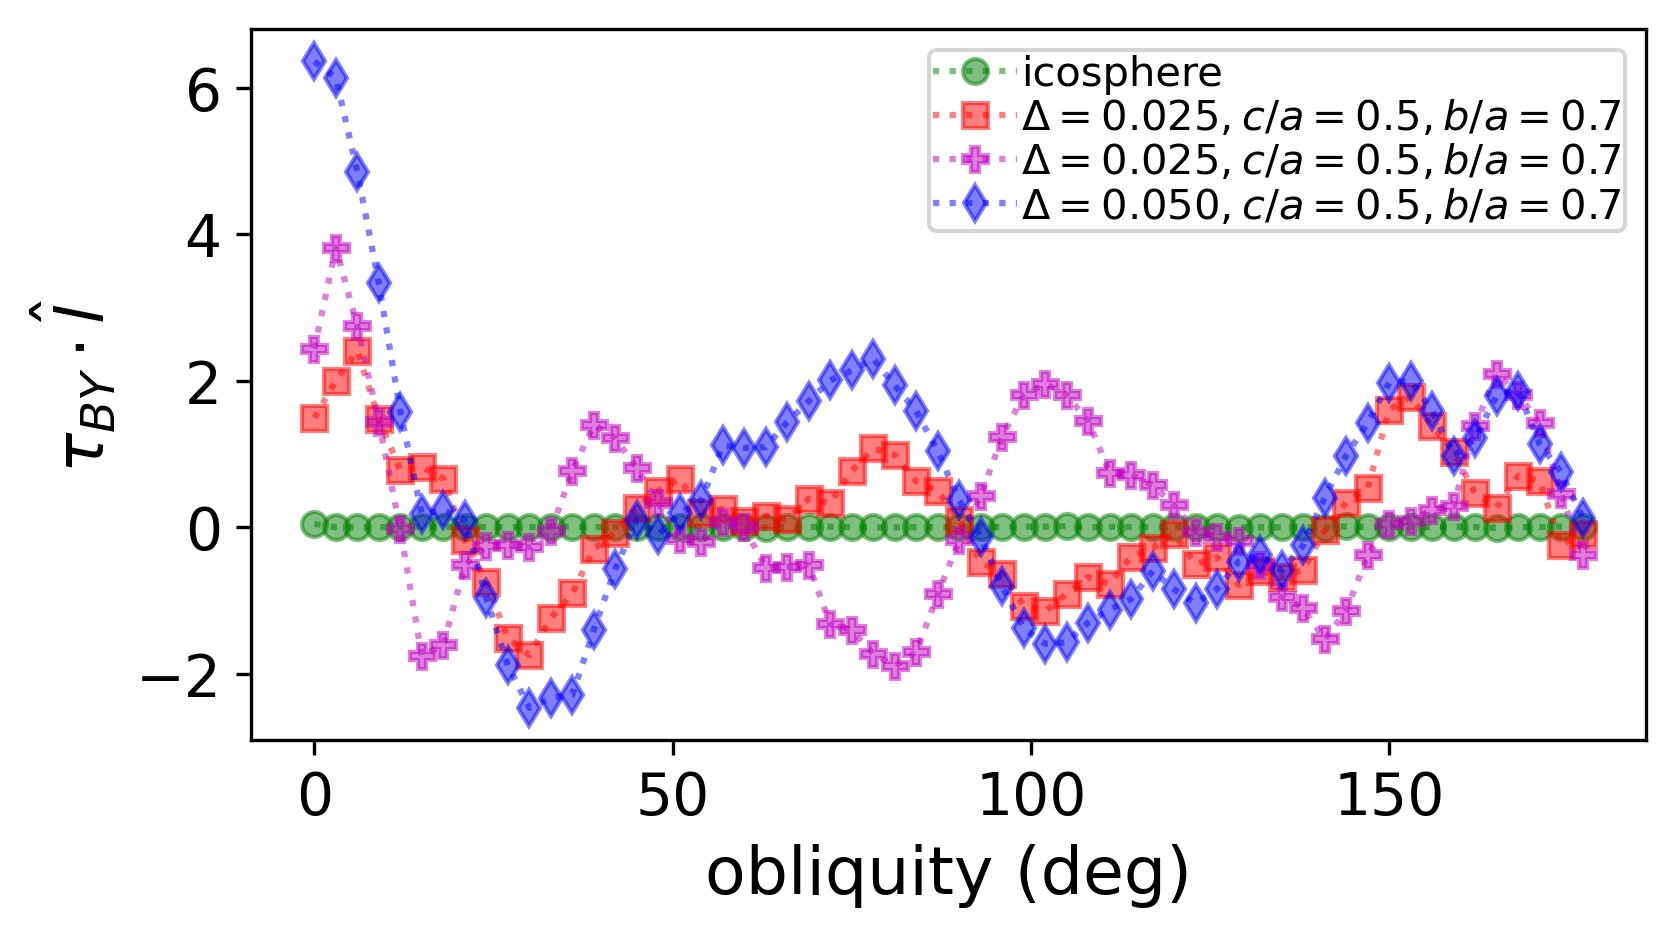

In [40]:
fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=300)
plt.subplots_adjust(bottom=0.19,top=0.98) 
ax.plot(o_arr_s,tau_l_arr_s,'go:',alpha=0.5,label='icosphere')
ax.plot(o_arr1,tau_l_arr1,'rs:',alpha=0.5,label=r'$\Delta=0.025, c/a=0.5, b/a=0.7$')
ax.plot(o_arr3,-tau_l_arr3,'mP:',alpha=0.5,label=r'$\Delta=0.025, c/a=0.5, b/a=0.7$')
ax.plot(o_arr2,tau_l_arr2,'bd:',alpha=0.5,label=r'$\Delta=0.050, c/a=0.5, b/a=0.7$')
#ax.plot(o_arr3,tau_l_arr3,'cv:',alpha=0.5,label=r'$\Delta=0.025, c/a=0.5, b/a=0.8$')
#ax.plot(o_arr4,tau_l_arr4,'mP:',alpha=0.5,label=r'$\Delta=0.025, c/a=0.6, b/a=0.7$')
ax.set_xlabel('obliquity (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend(borderpad=0.1,labelspacing=0.1,handletextpad=0.1)
plt.savefig('tau_BY_obl.png')

In [35]:
print(o_arr3[0:5])
print(-tau_l_arr3[0:5])

[ 0.  3.  6.  9. 12.]
[ 2.43709886  3.81366362  2.73905171  1.43368346 -0.03276348]


In [21]:
o_arr1a,tau_l_arr1a = obliq_BY_fig2(body1a,incl,phi_prec)
o_arr1b,tau_l_arr1b = obliq_BY_fig2(body1b,incl,phi_prec)

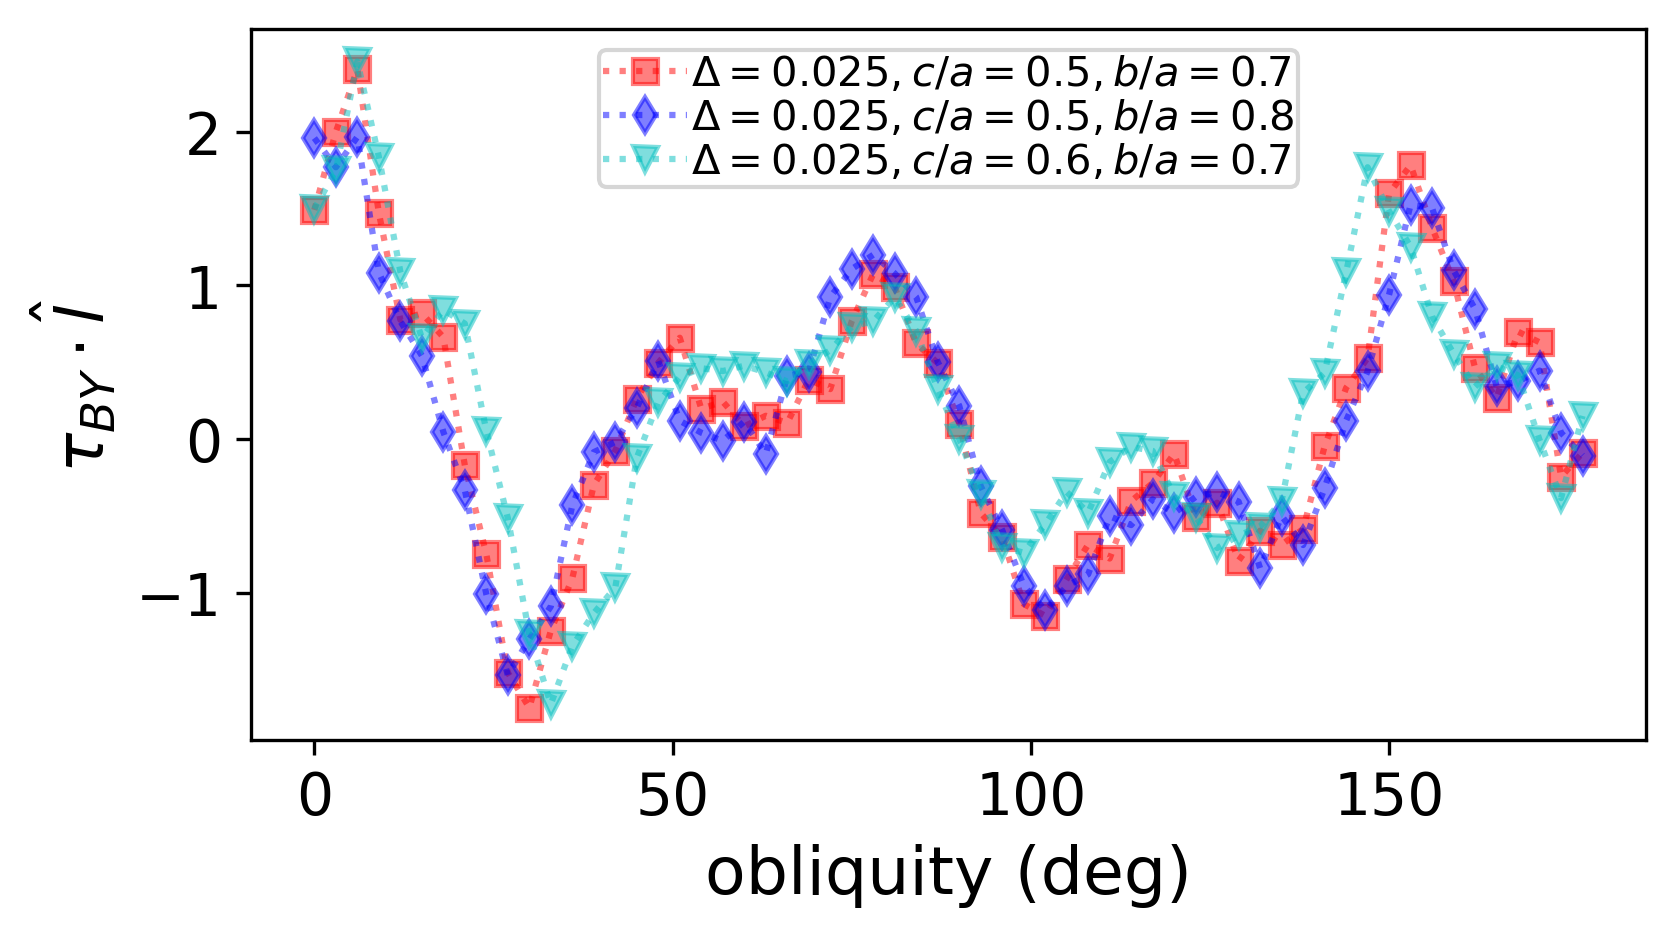

In [39]:
fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=300)
plt.subplots_adjust(bottom=0.19,top=0.98) 
#ax.plot(o_arr_s,tau_l_arr_s,'go:',alpha=0.5,label='sphere')
ax.plot(o_arr1 ,tau_l_arr1, 'rs:',alpha=0.5,label=r'$\Delta=0.025, c/a=0.5, b/a=0.7$')
ax.plot(o_arr1a,tau_l_arr1a,'bd:',alpha=0.5,label=r'$\Delta=0.025, c/a=0.5, b/a=0.8$')
ax.plot(o_arr1b,tau_l_arr1b,'cv:',alpha=0.5,label=r'$\Delta=0.025, c/a=0.6, b/a=0.7$')

ax.set_xlabel('obliquity (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend(borderpad=0.1,labelspacing=0.1,handletextpad=0.1)
plt.savefig('tau_BY_obl2.png')

In [9]:
# compute YORPs as a function of obliquity (single body, obliquity w.r.t Solar orbit)
o_arr, tau_s_arr, tau_o_arr = obliq_Y_fig(body1)
# also check the sphere for YORP
o_arr2, tau_s_arr2,tau_o_arr2  = obliq_Y_fig(sphere)  # note y axis

<ipython-input-5-881b499843ea>:36: RuntimeWarning: invalid value encountered in double_scalars
  phi_hat_x =  sy/spl
<ipython-input-5-881b499843ea>:37: RuntimeWarning: invalid value encountered in double_scalars
  phi_hat_y = -sx/spl


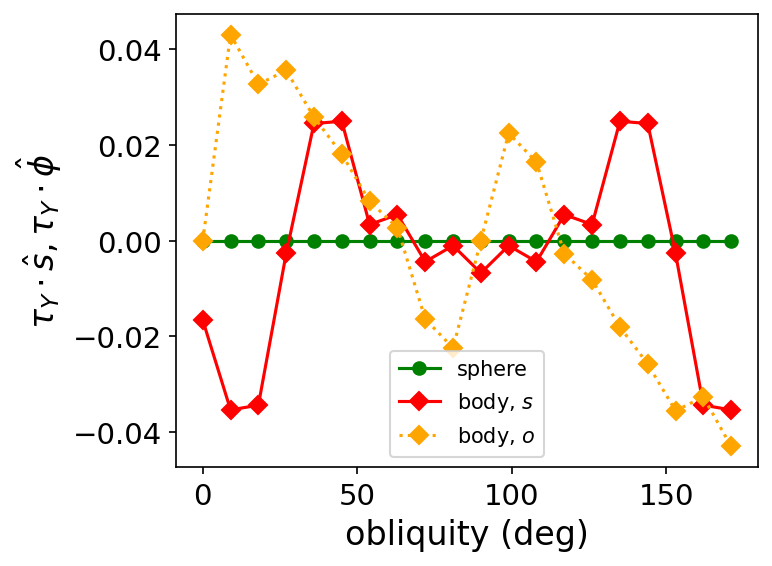

In [10]:
# compare the two YORPs
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
ax.plot(o_arr2,tau_s_arr2,'go-',label='sphere')
#ax.plot(o_arr2,tau_o_arr2,'bo-',label='sphere')
ax.plot(o_arr,tau_s_arr,'rD-',label=r'body, $s$')
ax.plot(o_arr,tau_o_arr,'D:',label='body, $o$', color='orange')
ax.set_xlabel('obliquity (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_Y \cdot \hat{ s}, { \tau}_Y \cdot \hat{\phi}$',fontsize=16)
ax.legend()

In [ ]:
# the sizes here agree with right hand side of Figure 3 by Steinberg&Sari+11

In [14]:
# compute BYORPs as a function of inclination
obliquity = 0; phi_prec=0
i_arr,tau_l_arr = obliq_BY_fig(body1,obliquity,phi_prec)
i_arr2,tau_l_arr2 = obliq_BY_fig(sphere,obliquity,phi_prec)

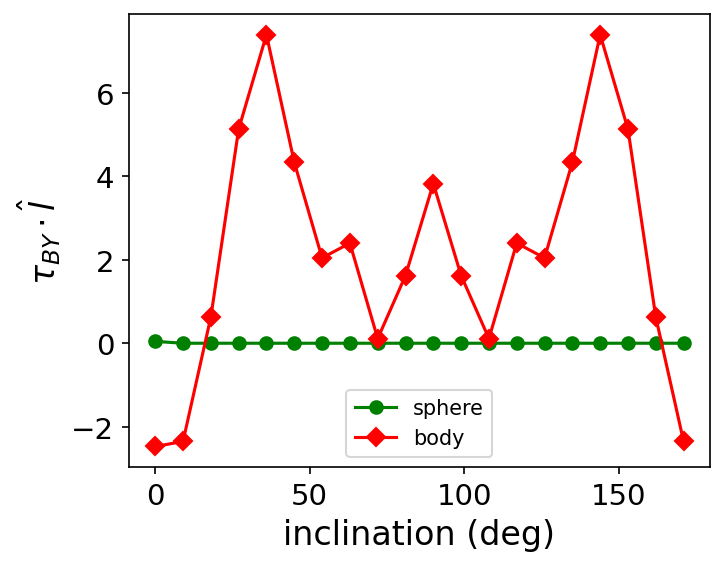

In [15]:
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
ax.plot(i_arr2,tau_l_arr2,'go-',label='sphere')
ax.plot(i_arr,tau_l_arr,'rD-',label='body')
ax.set_xlabel('inclination (deg)',fontsize=16)
ax.set_ylabel(r'${\tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend()

In [23]:
# compute BYORPs as a function of libration angle
incl = 0; phi_prec=0; obliquity = np.pi/4
l_arr,tau_l_arr=obliq_BY_fig4(body,obliquity,incl,phi_prec)

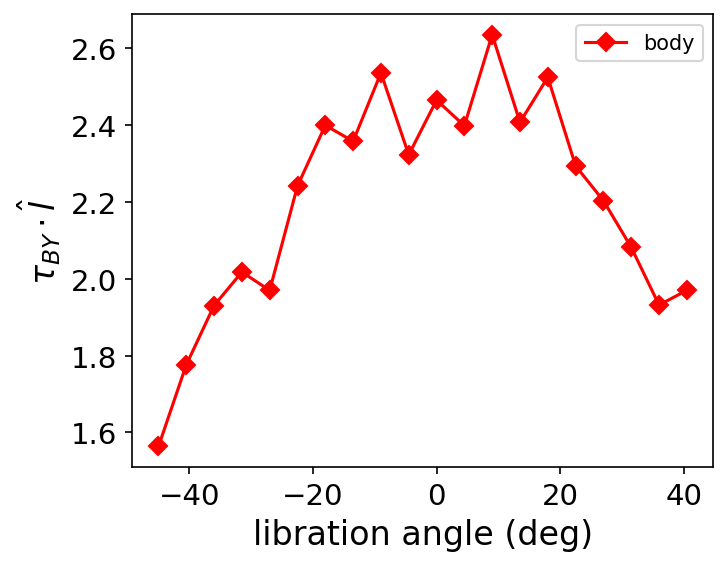

In [25]:
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
#ax.plot(o_arr2,tau_l_arr2,'go-',label='sphere')
ax.plot(l_arr,tau_l_arr,'rD-',label='body')
ax.set_xlabel('libration angle (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend()
#plt.savefig('tau_BY_lib.png')
# fairly sensitive to libration angle


### what next?

Normalize in terms of what Steinberg+11 used and compare drift rates
to the size of BYORPs estimated by other people. Done.

We need to figure out how the dimensionless constants used by Jacobson and Scheeres+11 compare with those
by Steinberg+11

Steinberg shows in their figure 4 that they expect similar sizes for the two dimensionless parameters.
Our computations are not consistent with that as we get larger BYORP (by a factor of about 100) than YORP coefficients.  However, our body is not round, compared to most of theirs.

We need to get a sphape model for something that has a YORP or BYORP prediction and check our code with it.
Try Moshup secondary called Squannit shape model

We need to explore sensitivity of our BYORP with obliquity with the shape model.



In [ ]:
# we seem to find that moderate obliquity variations can reverse BYORP, particularly for a non-round secondary.
# And this is for fixed obliquity, not chaotic ones. 
# We might be able to somewhat mitigate the tension between dissipation rate estimates
# and we would predict obliquity in Didymos! yay!

In [53]:
#https://www.naic.edu/~smarshal/1999kw4.html
#Squannit is secondary of Moshup which was 1999KW4

squannit = pymesh.load_mesh("kw4b.obj")
nf_mesh(squannit)
# we need to normalize it so that its volume is 4/3 pi
# to compute the volume of a tetrahdon that is made from a face + a vertex at the origin 
# we need to compute the determanent of a 3x3 matrix that consists of the 3 vertices in the face.
# we then sum over all faces in the mesh to get the total volume
# alternatively we use the generalized voxel thing in pymesh which is 4 vertices.
# to do this we add a vertex at the center and then we need to make the same number
# of voxels as faces using the vertex at the origin.
# and then we sum over the voxel_volume attributes of all the voxels.

number of faces  2292


In [54]:
xmax = 1.5
p = plt_mesh_square(squannit.vertices,squannit.faces,xmax)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.002731…

In [55]:
vol = volume_mesh(squannit)
print(vol)
R_squannit = pow(vol*3/(4.0*np.pi),0.3333333)
print(R_squannit)  # I don't know what units this is in. maybe km
# the object is supposed to have Beta: 0.571 x 0. 463 x 0.349 km (6% uncertainty)

0.048034509370524114
0.22550437981398924


In [56]:
# rescale so it has vol equiv sphere radius of 1
new_squannit = cor_volume(squannit)
p = plt_mesh_square(new_squannit.vertices,new_squannit.faces,xmax)

Volume 0.0480
radius of vol equ sphere 0.2255
new Volume 4.189


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012110…

In [57]:
xrot = np.array([1,0,0])
vrot = rotate_vertices(new_squannit.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot,new_squannit.faces,xmax)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012110…

In [69]:
# reduce the number of faces to something reasonable
short_squannit1, info = pymesh.collapse_short_edges(new_squannit, 0.219)  # if bigger then  fewer faces
nf_mesh(short_squannit1)
meshplot.plot(short_squannit1.vertices, short_squannit1.faces)
short_squannit2, info = pymesh.collapse_short_edges(new_squannit, 0.17)  # if bigger then  fewer faces
nf_mesh(short_squannit2)
meshplot.plot(short_squannit2.vertices, short_squannit2.faces)

number of faces  302


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.011542…

number of faces  534


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012885…

In [70]:
p = plt_mesh_square(short_squannit2.vertices,short_squannit2.faces,xmax)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012885…

In [71]:
xrot = np.array([1,0,0])
vrot = rotate_vertices(short_squannit2.vertices,xrot,np.pi/2)
p = plt_mesh_square(vrot,short_squannit2.faces,xmax)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.012885…

In [72]:
# compute BYORPs as a function of obliquity
incl = 0; phi_prec=0
o_arr1,tau_l_arr1 = obliq_BY_fig2(short_squannit1,incl,phi_prec)

In [73]:
# compute BYORPs as a function of obliquity
incl = 0; phi_prec=0
o_arr2,tau_l_arr2 = obliq_BY_fig2(short_squannit2,incl,phi_prec)

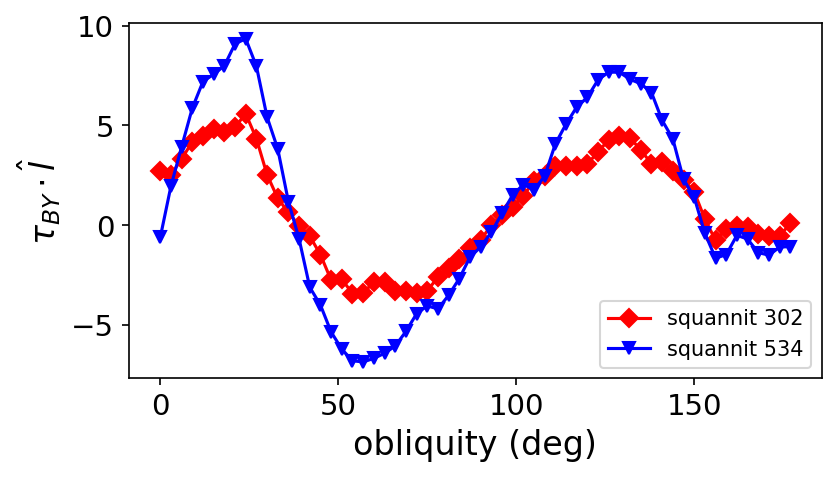

In [77]:
fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=150)
plt.subplots_adjust(bottom=0.19, top = 0.98,left=0.13)
#ax.plot(o_arr2,tau_l_arr2,'go-',label='sphere')
ax.plot(o_arr1,tau_l_arr1,'rD-',label='squannit 302')
ax.plot(o_arr2,tau_l_arr2,'bv-',label='squannit 534')
ax.set_xlabel('obliquity (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend()
plt.savefig('squannit.png')

In [82]:
from multiprocessing import Pool

#It's a great idea to use Pool but everything now needs to be global

class ob_info():
    def __init__(self,body):
        self.phi0 = 0
        self.nphi_Sun = 36
        self.nphi=36
        self.nobliq = 60
        self.incl = 0
        self.phi_prec = 0
        self.o_arr = np.zeros(self.nobliq)
        self.dobliq = np.pi/self.nobliq
        self.body = body
        for i in range(self.nobliq):
            obliquity=i*self.dobliq
            self.o_arr[i] = obliquity*180/np.pi
            
ob_stuff = ob_info(body1)

tau_l_arr = np.ctypeslib.as_ctypes(np.zeros((60)))
shared_array_tau = sharedctypes.RawArray(tau_l_arr._type_, tau_l_arr)

def f(i):
    body = ob_stuff.body
    obliquity = i*ob_stuff.dobliq
    nphi = ob_stuff.nphi
    nphi_Sun = ob_stuff.nphi_Sun
    incl = ob_stuff.incl
    phi0 = obstuff.phi0
    phi_prec = obstuff.phi_prec
    tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
    tau_l_arr[i] = tau_l
    
p = Pool()
pool.map(f, range(obstuff.nobliq))

    
# compute the BYORP torque on body as a function of obliquity
# for a given inclination and precession angle
# returns obliquity and torque arrays
def call_obliq_BY_fig2(body,incl,phi_prec):
    phi0=0
    nphi_Sun=36  # number of solar positions
    nphi = 36    # number of spin positions
    nobliq = 60   # number of obliquities
    dobliq = np.pi/nobliq
    #tau_l_arr = np.zeros(nobliq)  # to store torques
    o_arr = np.zeros(nobliq)
    
    tau_l_arr = np.ctypeslib.as_ctypes(np.zeros((60)))
    shared_array_tau = sharedctypes.RawArray(tau_l_arr._type_, tau_l_arr)
    for i in range(nobliq):
        obliquity=i*dobliq
        o_arr[i] = obliquity*180/np.pi
        
    for i in range(nobliq):
        obliquity=i*dobliq
        tau_BY_x,tau_BY_y,tau_BY_z, tau_l =compute_BY(body,obliquity,nphi,nphi_Sun,incl,phi0,phi_prec)
        tau_l_arr[i] = tau_l
    return o_arr,tau_l_arr

In [ ]:
# compute BYORPs as a function of precession angle, seems not sensitive to precession angle
incl = 0; #phi_prec=0
obliquity=np.pi/4
p_arr,tau_l_arr = obliq_BY_fig3(body,obliquity,incl)
p_arr2,tau_l_arr2 = obliq_BY_fig3(sphere,obliquity,incl)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
ax.plot(p_arr2,tau_l_arr2,'go-',label='sphere')
ax.plot(p_arr,tau_l_arr,'rD-',label='body')
ax.set_xlabel('precession angle (deg)',fontsize=16)
ax.set_ylabel(r'${ \tau}_{BY} \cdot \hat{l}$',fontsize=16)
ax.legend()

In [ ]:
# I don't understand why this has period 6
# It is very sensitive to obliquity but not to precession angle

In [ ]:
incl = 0  # this takes a really long time!
p_arr,o_arr,tau_l_arr_2D=obliq_BY_fig2D(body,incl)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=150)
ax.set_ylabel('precession angle (deg)',fontsize=16)
ax.set_xlabel('obliquity (deg)',fontsize=16)
maxt = np.max(tau_l_arr_2D)
mint = np.min(tau_l_arr_2D)
maxabs = max(abs(maxt),abs(mint))
im=ax.imshow(tau_l_arr_2D,  cmap='RdBu',vmin=-maxabs, vmax=maxabs,
        extent=[np.min(o_arr), np.max(o_arr), np.min(p_arr), np.max(p_arr)], origin='lower')
plt.colorbar(im)